# 

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
## check https://www.sdss4.org/dr17/irspec/apogee-bitmasks/ for more details

flag_descriptions = {
    0: "0: BAD_PIXELS - Excessive bad pixels",
    1: "1: COMMISSIONING - Non-standard config",
    2: "2: BRIGHT_NEIGHBOR - Bright neighbor",
    3: "3: VERY_BRIGHT_NEIGHBOR - Extremely bright neighbor",
    4: "4: LOW_SNR - Low signal/noise",
    9: "9: PERSIST_HIGH - High persistence",
    10: "10: PERSIST_MED - Medium persistence",
    11: "11: PERSIST_LOW - Low persistence",
    12: "12: PERSIST_JUMP_POS - Positive jump",
    13: "13: PERSIST_JUMP_NEG - Negative jump",
    16: "16: SUSPECT_RV_COMBINATION - RV mismatch",
    17: "17: SUSPECT_BROAD_LINES - Broad autocorrelation",
    18: "18: BAD_RV_COMBINATION - Significant RV mismatch",
    19: "19: RV_REJECT - RV rejection",
    20: "20: RV_SUSPECT - Slight RV difference",
    21: "21: MULTIPLE_SUSPECT - Multiple RV components",
    22: "22: RV_FAIL - RV failure",
    23: "23: SUSPECT_ROTATION - Suspected rotation",
    24: "24: MTPFLUX_LT_75 - Low fiber flux <0.75",
    25: "25: MTPFLUX_LT_50 - Very low fiber flux <0.5"
}


In [3]:
# def ensure_native_byteorder(array):
#     if array.dtype.byteorder not in ('=', '|'):  # '=' means native, '|' means not applicable
#         return array.byteswap().newbyteorder()  # Swap byte order to native
#     return array

# class APOGEEDataset(Dataset):
#     def __init__(self, directory, max_files=None):
#         """
#         Args:
#             directory (string): Directory with all the FITS files.
#             max_files (int): Maximum number of FITS files to load (optional).
#         """
#         self.abundances = []
#         self.flag_counts = {key: 0 for key in flag_descriptions.keys()}  # Initialize flag counters
#         self.both_flags_count = 0 # Initialize counter for stars with both flags 0 and 3
#         all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.fits')]
#         if max_files is not None and max_files < len(all_files):
#             self.files = random.sample(all_files, max_files)  # Randomly select max_files from the list
#         else:
#             self.files = all_files

#     def __len__(self):
#         return len(self.files)
    
#     def __getitem__(self, idx):
#         filepath = self.files[idx]
#         with fits.open(filepath) as hdul:
#             flux = hdul[1].data.astype(np.float32)
#             header = hdul[1].header
#             wavelength = self.calculate_wavelength(header, flux).astype(np.float32)
#             snr = self.get_snr(hdul)


#             teff = hdul[4].data['RV_TEFF'][0] if 'RV_TEFF' in hdul[4].columns.names else np.nan
#             logg = hdul[4].data['RV_LOGG'][0] if 'RV_LOGG' in hdul[4].columns.names else np.nan
#             feh = hdul[4].data['RV_FEH'][0] if 'RV_FEH' in hdul[4].columns.names else np.nan
#             ra = hdul[4].data['RA'][0]  
#             dec = hdul[4].data['DEC'][0] 
#             starflag = hdul[4].data['STARFLAG'][0] 
#             test_flag= hdul[4].data['STARFLAGS']

#             # if 'ASPCAPFLAG' in hdul[4].columns.names:
#             #     mask_flags = hdul[4].data['ASPCAPFLAG'].astype(np.int32)
#             # else:
#             #     mask_flags = np.zeros_like(flux, dtype=np.int32)  # Fallback to zeros if no mask data

#             abundances = hdul[4].data['FELEM'][0].astype(np.float32)
#             abundances = np.ascontiguousarray(abundances)
#             resolution = wavelength / (header['CDELT1'] * np.mean(wavelength))

        
            
#             for bit in flag_descriptions.keys():
#                 if starflag & (1 << bit):  # Check if the bit is set
#                     self.flag_counts[bit] += 1

#             # Check specifically if both flags 0 and 3 are set
#             if (starflag & (1 << 0)) or (starflag & (1 << 3)):
#                 self.both_flags_count += 1


#             # Ensure the arrays are in the native byte order
#             flux = ensure_native_byteorder(flux)
#             wavelength = ensure_native_byteorder(wavelength)
#             abundances = ensure_native_byteorder(abundances)
#             self.abundances.append(abundances)

#             # Convert to torch tensors
#             flux = torch.from_numpy(flux)
#             wavelength = torch.from_numpy(wavelength)
#             abundances = torch.from_numpy(abundances)
#             flux_mask = self.create_mask(flux.numpy())  
#             flux_mask = torch.from_numpy(flux_mask)

#             return {'wavelength': wavelength,
#                     'flux': flux,
#                     'snr': snr, 
#                     'teff': teff,
#                     'logg': logg, 
#                     'feh': feh,
#                     'abundances': abundances,
#                    'resolution': resolution,
#                    'ra': ra,
#                    'dec': dec,
#                    'flux_mask': flux_mask,
#                    'starflag':starflag,
#                    'test_flag': test_flag}

         
#     def calculate_wavelength(self,header, flux):
#         """
#         Calculates the wavelength array using the FITS header information.
#         """
#         crval = header['CRVAL1']  # Starting log10 wavelength
#         cdelt = header['CDELT1']  # Log10 wavelength increment
#         crpix = header['CRPIX1']  # Reference pixel
#         n_pixels = len(flux)
#         index = np.arange(n_pixels)
#         return 10 ** (crval + (index - (crpix - 1)) * cdelt)

#     def get_snr(self, hdul):
#         try:
#             snr = hdul[4].data['SNR'][0]
#             return snr if snr > 0 else 0
#         except KeyError:
#             return 0

#     def create_mask(self, flux):
#         """
#         Creates a mask for the flux array.
#         Args:
#             flux (ndarray): Array of flux values.
#         Returns:
#             ndarray: A mask array where the value is 0 if the corresponding flux is zero, and 1 otherwise.
#         """
#         return np.where(flux == 0, 0, 1)

    


In [4]:
def ensure_native_byteorder(array):
    if array.dtype.byteorder not in ('=', '|'):  # '=' means native, '|' means not applicable
        return array.byteswap().newbyteorder()  # Swap byte order to native
    return array

class APOGEEDataset(Dataset):
    def __init__(self, directory, max_files=None):
        """
        Args:
            directory (string): Directory with all the FITS files.
            max_files (int): Maximum number of FITS files to load (optional).
        """
        self.abundances = []
        self.flag_counts = {key: 0 for key in flag_descriptions.keys()}  # Initialize flag counters
        self.both_flags_count = 0 # Initialize counter for stars with both flags 0 and 3
        all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.fits')]
        if max_files is not None and max_files < len(all_files):
            self.files = random.sample(all_files, max_files)  # Randomly select max_files from the list
        else:
            self.files = all_files

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filepath = self.files[idx]
        with fits.open(filepath) as hdul:
            flux = hdul[1].data.astype(np.float32)
            header = hdul[1].header
            wavelength = self.calculate_wavelength(header, flux).astype(np.float32)
            snr = self.get_snr(hdul)


            teff = hdul[4].data['RV_TEFF'][0] if 'RV_TEFF' in hdul[4].columns.names else np.nan
            logg = hdul[4].data['RV_LOGG'][0] if 'RV_LOGG' in hdul[4].columns.names else np.nan
            feh = hdul[4].data['RV_FEH'][0] if 'RV_FEH' in hdul[4].columns.names else np.nan
            ra = hdul[4].data['RA'][0]  
            dec = hdul[4].data['DEC'][0] 
            
            starflag = hdul[4].data['STARFLAG'][0] 

            for bit in flag_descriptions.keys():
                if starflag & (1 << bit):  # Check if the bit is set
                    self.flag_counts[bit] += 1

            # Check specifically if both flags 0 and 3 are set
            if (starflag & (1 << 0)) or (starflag & (1 << 3)):
                self.both_flags_count += 1

            abundances = hdul[4].data['FELEM'][0].astype(np.float32)
            abundances = np.ascontiguousarray(abundances)
            resolution = wavelength / (header['CDELT1'] * np.mean(wavelength))




            # Ensure the arrays are in the native byte order
            flux = ensure_native_byteorder(flux)
            wavelength = ensure_native_byteorder(wavelength)
            abundances = ensure_native_byteorder(abundances)
            self.abundances.append(abundances)

            # Convert to torch tensors
            flux = torch.from_numpy(flux)
            wavelength = torch.from_numpy(wavelength)
            abundances = torch.from_numpy(abundances)
            flux_mask = self.create_mask(flux.numpy())  
            flux_mask = torch.from_numpy(flux_mask)

            return {'wavelength': wavelength,
                    'flux': flux,
                    'snr': snr, 
                    'teff': teff,
                    'logg': logg, 
                    'feh': feh,
                    'abundances': abundances,
                   'resolution': resolution,
                   'ra': ra,
                   'dec': dec,
                   'flux_mask': flux_mask,
                   'starflag':starflag}

         
    def calculate_wavelength(self,header, flux):
        """
        Calculates the wavelength array using the FITS header information.
        """
        crval = header['CRVAL1']  # Starting log10 wavelength
        cdelt = header['CDELT1']  # Log10 wavelength increment
        crpix = header['CRPIX1']  # Reference pixel
        n_pixels = len(flux)
        index = np.arange(n_pixels)
        return 10 ** (crval + (index - (crpix - 1)) * cdelt)

    def get_snr(self, hdul):
        try:
            snr = hdul[4].data['SNR'][0]
            return snr if snr > 0 else 0
        except KeyError:
            return 0

    def create_mask(self, flux):
        """
        Creates a mask for the flux array.
        Args:
            flux (ndarray): Array of flux values.
        Returns:
            ndarray: A mask array where the value is 0 if the corresponding flux is zero, and 1 otherwise.
        """
        return np.where(flux == 0, 0, )


In [5]:
directory = '../../projects/k-pop/spectra/apogee/dr17'
dataset = APOGEEDataset(directory, max_files=100)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

for i in range(len(dataset)):
    _ = dataset[i]



print(f"Number of stars with both flags 0 (BAD_PIXELS) and 3 (VERY_BRIGHT_NEIGHBOR): {dataset.both_flags_count}")


Number of stars with both flags 0 (BAD_PIXELS) and 3 (VERY_BRIGHT_NEIGHBOR): 0


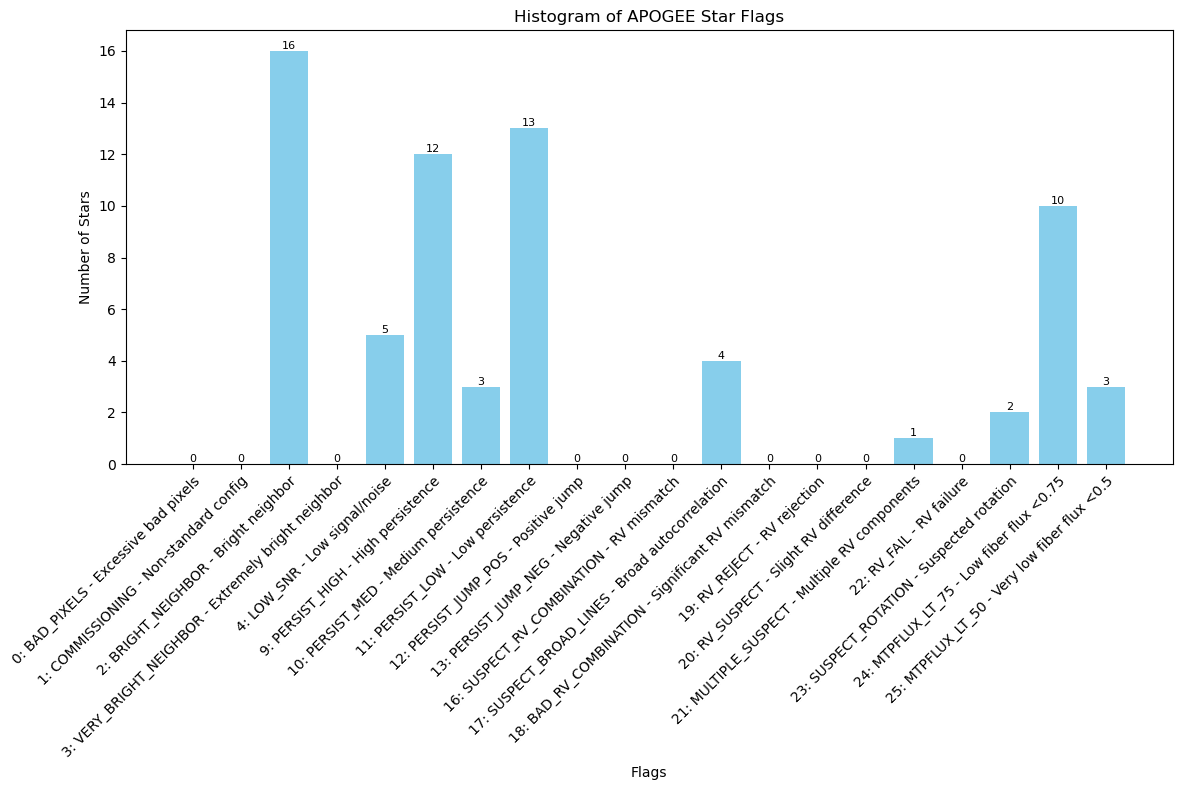

In [6]:
def plot_flags_histogram(flag_counts, flag_descriptions):
    labels = [flag_descriptions[bit] for bit in sorted(flag_counts.keys())]
    counts = [flag_counts[bit] for bit in sorted(flag_counts.keys())]
    plt.figure(figsize=(12, 8))
    bars = plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Flags')
    plt.ylabel('Number of Stars')
    plt.title('Histogram of APOGEE Star Flags')
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_flags_histogram(dataset.flag_counts, flag_descriptions)

In [7]:
def plot_spectrum(wavelength, flux):
    """
    Plots the spectrum using wavelength and flux data.
    Args:
        wavelength (Tensor): Wavelength data as a PyTorch tensor.
        flux (Tensor): Flux data as a PyTorch tensor.
    """
    # Convert PyTorch tensors to numpy arrays for plotting
    wavelength = wavelength.numpy()
    flux = flux.numpy()
    
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label='Spectrum')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('APOGEE Spectrum')
    plt.legend()
    plt.show()


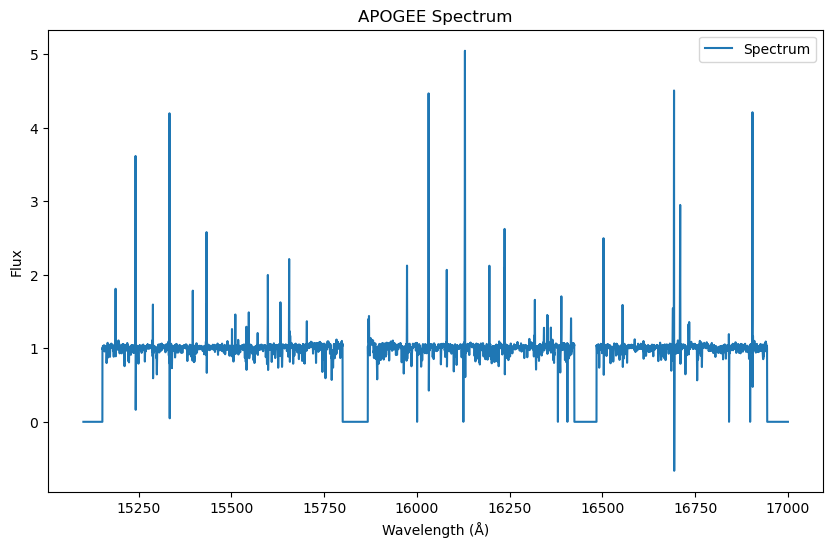

In [8]:
for data in dataloader:
    wavelengths, fluxes = data['wavelength'], data['flux']
    plot_spectrum(wavelengths[0], fluxes[0])  # Plot the first spectrum in the batch
   
    break

In [9]:
def plot_parameter_distribution(dataloader, param_name, bins=30, title=None):
    values_list = []  # Use a list to collect tensors
    # Wrap the dataloader with tqdm for a progress bar
    for data in tqdm(dataloader, desc=f"Processing {param_name}"):
        vals = data[param_name]
        
        # Ensure numpy array is in native byte order before conversion to tensor
        if isinstance(vals, np.ndarray) and vals.dtype.byteorder not in ('=', '|'):
            vals = vals.byteswap().newbyteorder()

        # Remove NaN values directly using PyTorch
        mask = ~torch.isnan(vals)
        valid_vals = vals[mask]  # Use a boolean tensor for indexing
        values_list.append(valid_vals)  # Append valid values to the list

    # Concatenate all valid values into a single tensor after the loop
    values = torch.cat(values_list, dim=0)

    plt.figure(figsize=(10, 6))
    plt.hist(values.numpy(), bins=bins, alpha=0.75, color='blue')  # Convert to numpy for plotting
    plt.title(title or f'Distribution of {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Print statistics if needed
    if values.numel() > 0:  # Use numel to check for number of elements in tensor
        print(f"Mean {param_name}: {torch.mean(values).item():.2f}")
        print(f"Median {param_name}: {torch.median(values).item():.2f}")
        print(f"Standard Deviation of {param_name}: {torch.std(values).item():.2f}")
    else:
        print("No valid values found. Check your dataset and field names.")


In [10]:

def plot_spectrum_with_mask(wavelength, flux, mask):
    """
    Plots the spectrum and mask using wavelength, flux, and mask data.
    Args:
        wavelength (Tensor): Wavelength data as a PyTorch tensor.
        flux (Tensor): Flux data as a PyTorch tensor.
        mask (Tensor): Mask data as a PyTorch tensor, with values 0 or 1.
    """
    # Convert PyTorch tensors to numpy arrays for plotting
    wavelength = wavelength.numpy()
    flux = flux.numpy()
    mask = mask.numpy() * flux.max()  # Scale mask for visibility on the flux plot

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label='Spectrum', color='blue', linestyle='-', linewidth=0.5)
    plt.plot(wavelength, mask, label='Mask', color='red', linestyle='-', linewidth=0.5)
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('APOGEE Spectrum with Mask')
    plt.legend()
    plt.show()





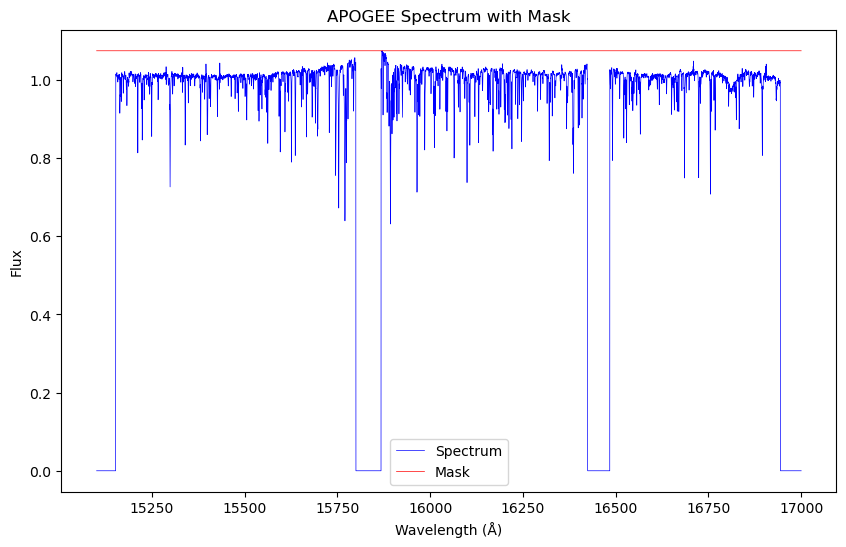

In [11]:
for data in dataloader:
    wavelengths, fluxes, masks = data['wavelength'], data['flux'], data['flux_mask']
    plot_spectrum_with_mask(wavelengths[0], fluxes[0], masks[0])  # Plot the first spectrum and mask in the batch
    break

Processing snr: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


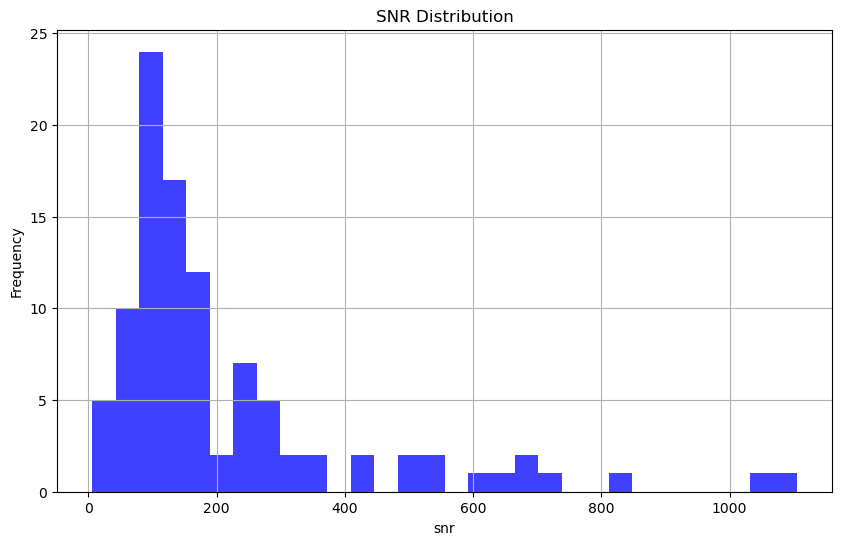

Mean snr: 213.60
Median snr: 135.75
Standard Deviation of snr: 208.14


Processing teff: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


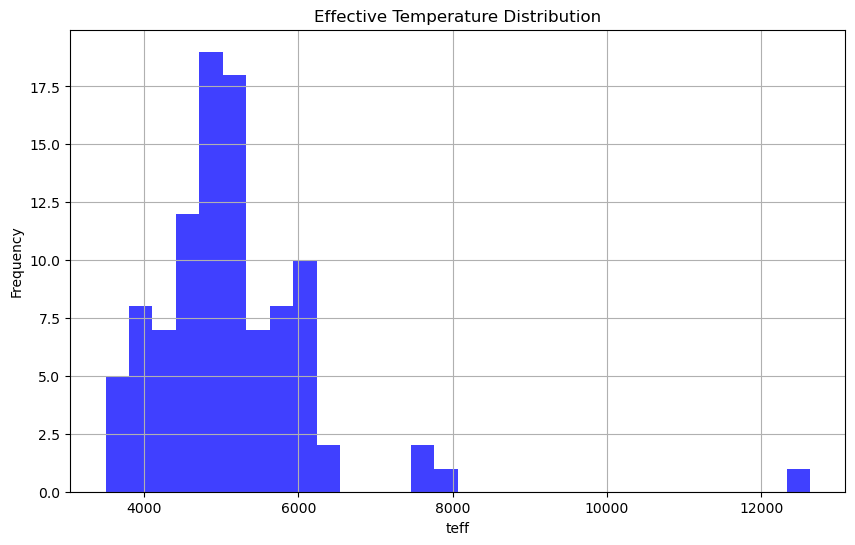

Mean teff: 5131.38
Median teff: 4989.12
Standard Deviation of teff: 1125.25


Processing logg: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


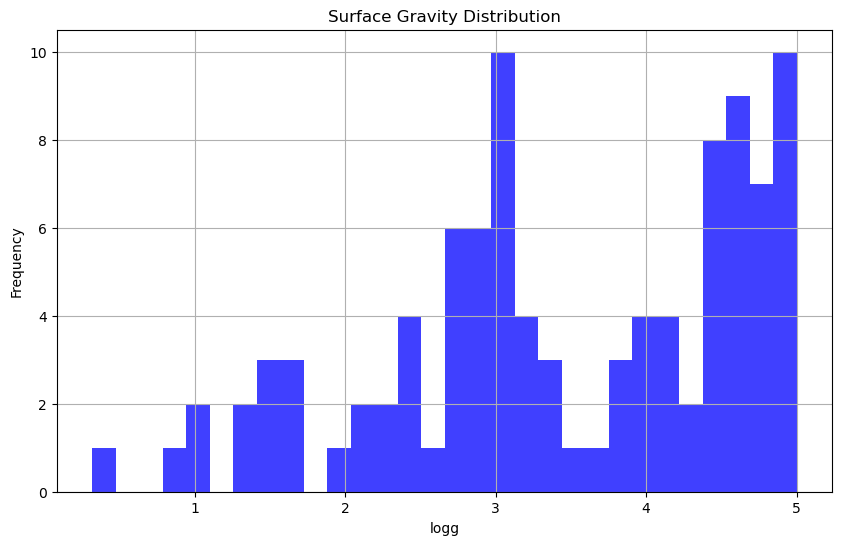

Mean logg: 3.46
Median logg: 3.38
Standard Deviation of logg: 1.19


Processing feh: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


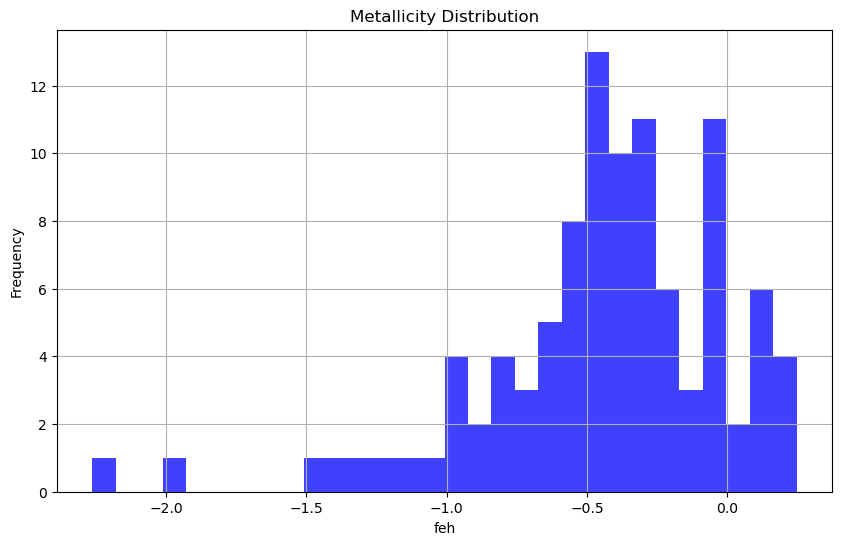

Mean feh: -0.44
Median feh: -0.37
Standard Deviation of feh: 0.44


In [12]:
plot_parameter_distribution(dataloader, 'snr', bins=30, title='SNR Distribution')
plot_parameter_distribution(dataloader, 'teff', bins=30, title='Effective Temperature Distribution')
plot_parameter_distribution(dataloader, 'logg', bins=30, title='Surface Gravity Distribution')
plot_parameter_distribution(dataloader, 'feh', bins=30, title='Metallicity Distribution')


In [13]:
for data in dataloader:
    abundances = data['abundances']
    print(abundances)


    break

tensor([[ 1.0441e-01,  9.6975e-02,  2.3642e-01,  3.2650e-01, -6.1498e-01,
          2.4516e-01,  9.0611e-03,  2.5462e-01, -9.6988e-01,  2.4572e-01,
         -7.2896e-02,  2.1933e-01,  1.9355e-01,  3.8261e-01, -3.5022e-01,
         -5.2327e-01, -6.7935e-01, -4.7139e-01, -3.9004e-01, -3.9721e-01,
         -1.1976e+00,         nan,         nan, -5.8736e-01, -2.4334e-01,
                 nan, -2.5231e-02],
        [-1.9562e-02,  4.1500e-02, -9.4959e-02, -2.7926e-02, -1.7174e-01,
         -1.4496e-01, -1.1237e-01, -2.0605e-01, -1.0773e+00,  2.7041e-01,
         -5.6968e-02,  6.4570e-02, -6.0356e-02,  9.9961e-01, -4.8997e-01,
         -4.8082e-02, -3.5543e-01, -1.2358e-01,  2.2361e-01, -2.1625e-01,
          2.6571e-01,         nan,         nan,  1.1402e-01,  3.4917e-02,
                 nan,  5.4615e-02],
        [ 1.3004e-01,  1.7199e-01,  1.3045e-01,  3.0125e-01, -4.0419e-01,
          3.1610e-01,  6.1040e-03,  2.7025e-01, -4.7166e-01,  2.7272e-01,
         -1.3341e-01,  2.0651e-01,  1.84

In [14]:
for batch in dataloader:
    print(batch['wavelength'].shape, batch['flux'].shape, batch['abundances'].shape)
    break


torch.Size([10, 8575]) torch.Size([10, 8575]) torch.Size([10, 27])


In [15]:
def plot_element_distribution(dataloader, element_index, title=None):
    element_values = []  # List to hold all the abundance values for the specified element
    
    # Iterate through the dataloader to extract the specified element's abundance
    for data in tqdm(dataloader, desc="Extracting element data"):
        abundances = data['abundances']  # Assuming 'abundances' is a key in your data dictionary
        # Append the value at the specified index for each star
        # Use .item() to get the value as a float from the tensor
        element_values.extend(abundances[:, element_index].detach().numpy().tolist())

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(element_values, bins=30, alpha=0.75, color='blue')
    plt.title(title or f'Distribution of Element at Index {element_index}')
    plt.xlabel('Abundance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Extracting element data: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


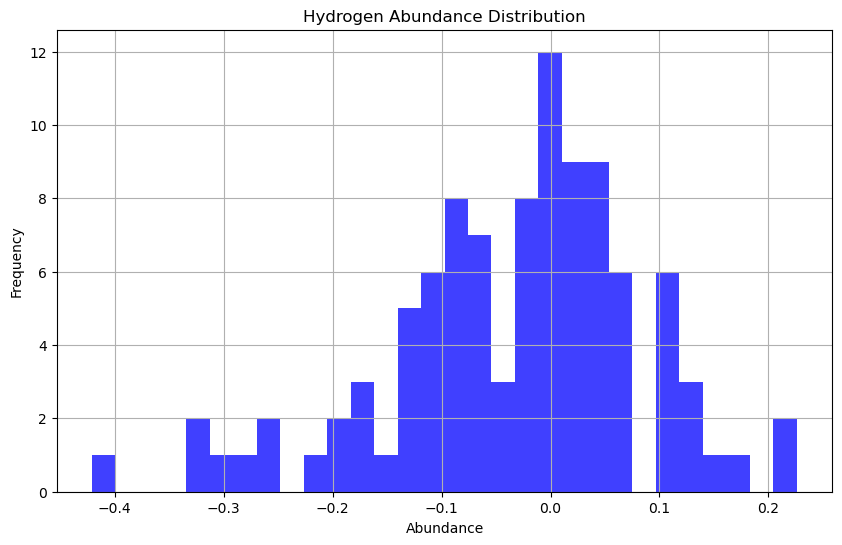

In [16]:
plot_element_distribution(dataloader, 0, title="Hydrogen Abundance Distribution")


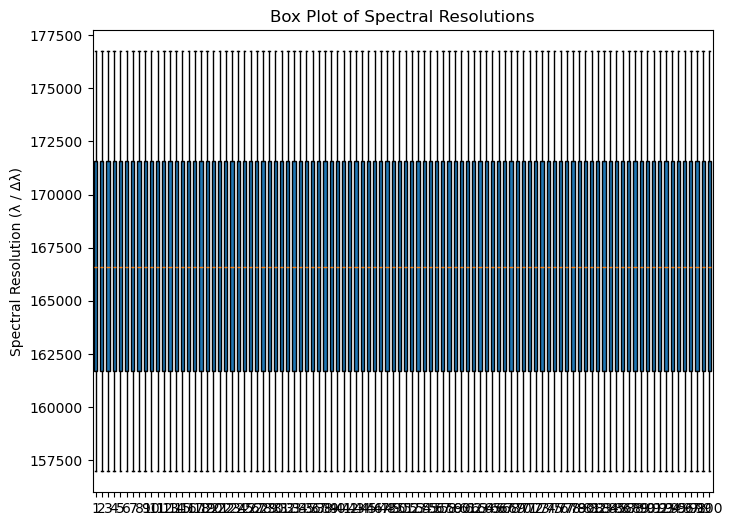

In [17]:
def plot_boxplot_resolution(dataloader):
    resolutions = []
    # Iterate through the DataLoader
    for data in dataloader:
        # Append resolution data from each batch
        batch_resolutions = data['resolution'].detach().cpu().numpy()  # Assuming resolution is a tensor
        resolutions.extend(batch_resolutions)
    
    # Plotting the data
    plt.figure(figsize=(8, 6))
    plt.boxplot(resolutions, vert=True, patch_artist=True)
    plt.title('Box Plot of Spectral Resolutions')
    plt.ylabel('Spectral Resolution (λ / Δλ)')
    # plt.grid(True)
    plt.show()
    
# Assuming you have a DataLoader set up as before
plot_boxplot_resolution(dataloader)



### NOT SURE WHAT TO SEE HERE 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data loading and cleaning
# Initialize lists to collect data
data_collect = {'snr': [], 'teff': [], 'logg': [], 'feh': []}

# Assuming 'dataloader' is already defined and properly set up
for data in dataloader:
    
 
    data_collect['snr'].extend(data['snr'].cpu().numpy())
    data_collect['teff'].extend(data['teff'].cpu().numpy())
    data_collect['logg'].extend(data['logg'].cpu().numpy())
    data_collect['feh'].extend(data['feh'].cpu().numpy())



# Convert lists to DataFrame
df = pd.DataFrame(data_collect)

# print(df) 

# Drop any rows with NaN values for simplicity or fill them
df.dropna(inplace=True)

# Plotting
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.show()


In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

def plot_apogee_coverage(dataloader):
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111, projection="mollweide")
    ax.grid(True)

    for batch in dataloader:
        ra = batch['ra'].numpy()  # Assuming RA is directly available and in degrees
        dec = batch['dec'].numpy()  # Assuming DEC is directly available and in degrees

        # Convert RA, DEC to radians for the plot
        ra_rad = np.radians(ra - 180)  # Adjust RA for the plot
        dec_rad = np.radians(dec)

        ax.scatter(ra_rad, dec_rad, alpha=0.5, s=10)

    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    ax.set_title('Coverage of APOGEE Survey on the Sky')
    plt.show()


plot_apogee_coverage(dataloader)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_aspcap_flags_histogram(dataset):
#     flags_count = np.zeros(28, dtype=int)  # There are 28 possible flags
#     for data in dataset:
#         flags = data['aspcapflag']
#         for i in range(28):
#             if flags & (1 << i):  # Check if the ith bit is set
#                 flags_count[i] += 1

#     # Define labels for each flag, ensuring each flag has a label
#     labels = [
#         "GridEdge Bad (0)", "CalRange Bad (1)", "Other Bad (2)", 
#         "FERRE Fail (3)", "Param Mismatch Bad (4)", "FERRE Err Used (5)", 
#         "Teff Cut (6)", "Reserved (7)", "GridEdge Warn (8)", "CalRange Warn (9)",
#         "Other Warn (10)", "FERRE Warn (11)", "Param Mismatch Warn (12)",
#         "Optical Warn (13)", "Err Warn (14)", "Faint Warn (15)",
#         "Param Fixed (16)", "RV Warn (17)", "Reserved (18)", "Reserved (19)",
#         "Reserved (20)", "Reserved (21)", "Reserved (22)", "Reserved (23)",
#         "Spec RC (24)", "Spec RGB (25)", "Logg Cal MS (26)", "Logg Cal RGB MS (27)"
#     ]

#     # Plot histogram
#     plt.figure(figsize=(18, 8))
#     bars = plt.bar(range(28), flags_count, tick_label=labels)
#     plt.xlabel('ASPCAP Flags')
#     plt.ylabel('Count')
#     plt.title('Histogram of ASPACAP Flags')
#     plt.xticks(rotation=90)  # Rotate labels to avoid overlap
#     plt.tight_layout()  # Adjust layout to make room for label rotation
#     plt.show()

# # Example of how to use the function
# # plot_aspcap_flags_histogram(apogee_dataset)
